In [139]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 9) #set figsize for all

In [3]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 'Timezone', 'DST', 'Tz', 'type', 'source']
airports = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',
                     names=airport_col, index_col=0)
airports.head()

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [4]:
route_col = ['Airline', 'Airline_ID', 'Source', 'Source_ID', 'Dest', 'Dest_ID', 'Codeshare', 'Stops', 'equipment']
routes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat',
                     names=route_col, index_col=0)
routes.head()

,Airline_ID,Source,Source_ID,Dest,Dest_ID,Codeshare,Stops,equipment
Airline,,,,,,,,
2B,410,AER,2965,KZN,2990,NaN,0,CR2
2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2B,410,ASF,2966,MRV,2962,NaN,0,CR2
2B,410,CEK,2968,KZN,2990,NaN,0,CR2
2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [5]:
airports['Country'].value_counts().sort_values(ascending=False)

United States    1512
Canada            430
Australia         334
Russia            264
Brazil            264
                 ... 
Bermuda             1
Gambia              1
Barbados            1
Martinique          1
Nauru               1
Name: Country, Length: 237, dtype: int64

In [100]:
# Get Vietnam airport keys
airport_vn_keys = airports[airports['Country'] == 'Vietnam']['IATA'].unique().tolist() #list
print(airport_vn_keys)
route_vn = routes[(routes['Source'].isin(airport_vn_keys)) | (routes['Dest'].isin(airport_vn_keys))] #df

# Group by unique routes since some codeshared airlines are listed multiple times
route_vn =  pd.DataFrame(route_vn.groupby(['Source', 'Dest']).size().reset_index(name='airline_count'))
print("There are {0} unique flight routes in and out of Vietnam.".format(len(route_vn)))

['DAD', '\\N', 'HAN', 'NHA', 'HUI', 'PQC', 'SGN', 'DLI', 'VDH', 'VKG', 'CAH', 'VCL', 'TBB', 'BMV', 'HPH', 'CXR', 'VCS', 'VCA', 'DIN', 'UIH', 'PXU', 'VII', 'PHA', 'SQH']
There are 244 unique flight routes in and out of Vietnam.


In [94]:
# Get flight count in and out of an airport, counting both ways
count = route_vn['Source'].append(route_vn['Dest']).value_counts()
count = pd.DataFrame({'IATA':count.index, 'flight_count':count.values})

# Merge to airport df
airport_vn_foreign_keys = route_vn['Source'].append(route_vn['Dest']).unique().tolist() #list
airport_vn_foreign = pd.merge(airports[airports['IATA'].isin(airport_vn_foreign_keys)], 
                              count[count['IATA'].isin(airport_vn_foreign_keys)], 
                              on=['IATA'], how='outer') #outer full join

In [157]:
edge_df = route_vn
node_df = airport_vn_foreign[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long', 'flight_count']]

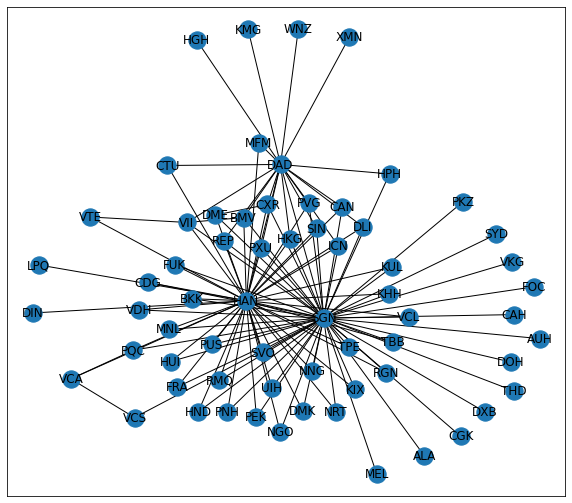

In [142]:
G = nx.from_pandas_edgelist(route_vn, source = 'Source', target = 'Dest', edge_attr='airline_count')

nx.draw_networkx(G)
plt.show()

In [144]:
# We start from a blank nx graph, this time with Long, Lat as node position
G = nx.Graph()

for node in airport_vn_foreign_keys:
    G.add_node(node)

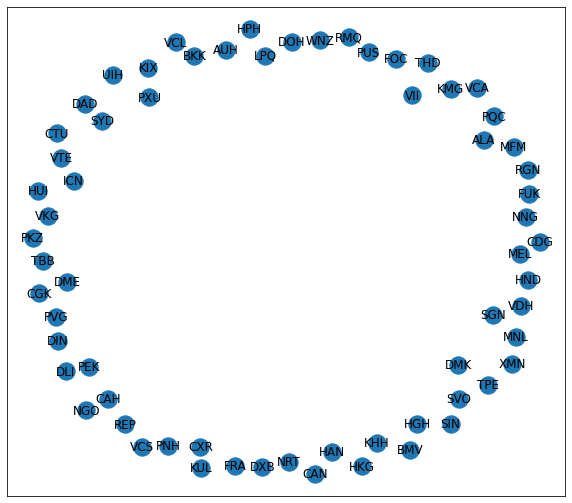

In [145]:
# At every step, we can draw graph by:
nx.draw_networkx(G)
plt.show()

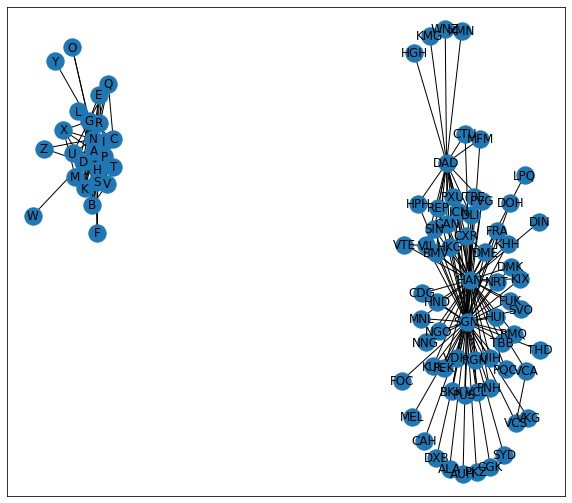

In [151]:
for index, row in route_vn.iterrows():
    G.add_edges_from(zip(row['Source'], row['Dest']), weight=row['airline_count'])

nx.draw_networkx(G)
plt.show()

In [152]:
x, y = airport_vn_foreign['Long'].values, airport_vn_foreign['Lat'].values

pos_dict = {}
for index, airport_code in enumerate(airport_vn_foreign['IATA']):
    pos_dict[airport_code] = (x[index], y[index])

In [127]:
pos = nx.spring_layout(G, pos=pos_dict, k=0.5, iterations=50)

In [118]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]].map(pos)

AttributeError: 'Graph' object has no attribute 'node'

In [74]:
fig = go.Figure(graph)

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [<networkx.classes.digraph.DiGraph object at 0x7ffde1e85f90>]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['area', 'bar', 'barpolar', 'box',
                     'candlestick', 'carpet', 'choropleth',
                     'choroplethmapbox', 'cone', 'contour',
                     'contourcarpet', 'densitymapbox', 'funnel',
                     'funnelarea', 'heatmap', 'heatmapgl',
                     'histogram', 'histogram2d',
                     'histogram2dcontour', 'image', 'indicator',
                     'isosurface', 'mesh3d', 'ohlc', 'parcats',
                     'parcoords', 'pie', 'pointcloud', 'sankey',
                     'scatter', 'scatter3d', 'scattercarpet',
                     'scattergeo', 'scattergl', 'scattermapbox',
                     'scatterpolar', 'scatterpolargl',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])